In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)  # , force_remount=True
%cd gdrive/My\ Drive/Resources/Dev\ Stuff/Python/Machine\ Learning/Doctoral\ Dissertation/
import os
os.getcwd()
import tensorflow as tf
tf.test.gpu_device_name()
!pip install -r requirements.txt  # -q

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Mounted at /content/gdrive
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-f48780235033>", line 3, in <cell line: 3>
    get_ipython().run_line_magic('cd', 'gdrive/My\\ Drive/Resources/Dev\\ Stuff/Python/Machine\\ Learning/Doctoral\\ Dissertation/')
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback

# 🎶 Music Generation - MuseGAN

In this notebook, we'll walk through the steps required to train your own MuseGAN model to generate music in the style of the Bach chorales

In [11]:
import mido
import numpy as np

def extract_midi_data(filename, voices=4):
    mid = mido.MidiFile(filename)

    # Dictionary to store time signature changes: { measure: (numerator, denominator) }
    time_signatures = {}
    current_time = 0
    current_measure = 1
    for track in mid.tracks:
        try:
            for msg in track:
                if msg.type == 'time_signature':
                    time_signatures[current_measure] = (msg.numerator, msg.denominator)
                current_time += msg.time
                # If we cross a bar boundary, increment current_measure
                if current_time >= mid.ticks_per_beat * 4:  # Assuming a quarter note has the base duration
                    current_measure += 1
                    current_time -= mid.ticks_per_beat * 4
        except:
            pass

    # If no time signature is found, default to 4/4
    if not time_signatures or 1 not in time_signatures:
        time_signatures[1] = (4, 4)

    # Calculate total timesteps based on the MIDI file length
    total_time = sum(msg.time for track in mid.tracks for msg in track)
    total_timesteps = int(total_time / (mid.ticks_per_beat / 4))  # Base timesteps on quarter notes for now

    # Placeholder for extracted data initialized with rests (0s)
    data = np.zeros((total_timesteps, voices))

    # Define a dictionary to track the end time of the last note for each voice
    last_note_end = {i: 0 for i in range(voices)}

    current_time_signature = time_signatures[1]  # Start with the first time signature
    current_time = 0
    current_measure = 1

    # print("Track names: " + str([track.name for track in mid.tracks]))

    for voice, track in enumerate(mid.tracks):
        try:
            for msg in track:
                current_time += msg.time
                # Update current_measure and current_time_signature based on elapsed time
                while current_time >= mid.ticks_per_beat * current_time_signature[0]:
                    current_measure += 1
                    current_time -= mid.ticks_per_beat * current_time_signature[0]
                    if current_measure in time_signatures:
                        current_time_signature = time_signatures[current_measure]

                timesteps_per_bar = current_time_signature[0] * (4 / current_time_signature[1]) * 4
                step = int(current_time / (mid.ticks_per_beat / timesteps_per_bar))

                # If note_on with velocity 0 or note_off, it's the end of the note
                if (msg.type == 'note_on' and msg.velocity == 0) or msg.type == 'note_off':
                    last_note_end[voice] = step

                # If a note starts, fill all timesteps from the last note's end until the current step
                elif msg.type == 'note_on' and msg.velocity > 0:
                    for s in range(last_note_end[voice], step):
                        data[s][voice] = msg.note

                    last_note_end[voice] = step
        except KeyError:
            # print("Skipping control track")
            continue

    # Fill any remaining timesteps after the last note with rests
    for voice, end in last_note_end.items():
        for s in range(end, total_timesteps):
            data[s][voice] = 0  # 0 represents a rest

    return data


In [12]:
import os

directory = "Data/MIDI/VoiceParts/Combined"
all_data = []

def iterate_and_add(path):
    for indx, filename in enumerate(os.listdir(path)):
        if filename.lower().endswith(".mid") or filename.lower().endswith(".midi"):
            print(f"{indx} Processing {filename}")
            file_path = os.path.join(path, filename)
            data = extract_midi_data(file_path)
            all_data.append(data)

# iterate_and_add(directory)
#
# include_augmented = True
# if include_augmented:
#     for i in range(1, 5):
#         iterate_and_add(f"{directory}/Augment_{i}")

In [13]:
# # Shuffle data
# import random
# random.shuffle(all_data)
#
# train_size = int(0.7 * len(all_data))
# valid_size = int(0.15 * len(all_data))
#
# train_data = all_data[:train_size]
# valid_data = all_data[train_size:train_size+valid_size]
# test_data = all_data[train_size+valid_size:]
#
# np.savez('Data/Glob/Choral/Choral.npz', train=train_data, valid=valid_data, test=test_data)

# Model

In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import os
import tensorflow as tf
from keras import (
    layers,
    models,
    optimizers,
    callbacks,
    initializers,
    metrics,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import music21
import numpy as np
from matplotlib import pyplot as plt


def binarise_output(output):
    # output is a set of scores: [batch size , steps , pitches , tracks]
    max_pitches = np.argmax(output, axis=3)
    return max_pitches


def notes_to_midi(output, n_bars, n_tracks, n_steps_per_bar, filename):
    for score_num in range(len(output)):
        max_pitches = binarise_output(output)
        midi_note_score = max_pitches[score_num].reshape(
            [n_bars * n_steps_per_bar, n_tracks]
        )
        parts = music21.stream.Score()
        parts.append(music21.tempo.MetronomeMark(number=66))
        for i in range(n_tracks):
            last_x = int(midi_note_score[:, i][0])
            s = music21.stream.Part()
            dur = 0
            for idx, x in enumerate(midi_note_score[:, i]):
                x = int(x)
                if (x != last_x or idx % 4 == 0) and idx > 0:
                    n = music21.note.Note(last_x)
                    n.duration = music21.duration.Duration(dur)
                    s.append(n)
                    dur = 0
                last_x = x
                dur = dur + 0.25
            n = music21.note.Note(last_x)
            n.duration = music21.duration.Duration(dur)
            s.append(n)
            parts.append(s)
        parts.write(
            "midi", fp="./Data/Generated/ChoralGAN/{}_{}.midi".format(filename, score_num)
        )


def draw_bar(data, score_num, bar, part):
    plt.imshow(
        data[score_num, bar, :, :, part].transpose([1, 0]),
        origin="lower",
        cmap="Greys",
        vmin=-1,
        vmax=1,
    )


def draw_score(data, score_num):
    n_bars = data.shape[1]
    n_tracks = data.shape[-1]

    fig, axes = plt.subplots(
        ncols=n_bars, nrows=n_tracks, figsize=(12, 8), sharey=True, sharex=True
    )
    fig.subplots_adjust(0, 0, 0.2, 1.5, 0, 0)

    for bar in range(n_bars):
        for track in range(n_tracks):
            if n_bars > 1:
                axes[track, bar].imshow(
                    data[score_num, bar, :, :, track].transpose([1, 0]),
                    origin="lower",
                    cmap="Greys",
                )
            else:
                axes[track].imshow(
                    data[score_num, bar, :, :, track].transpose([1, 0]),
                    origin="lower",
                    cmap="Greys",
                )

## 0. Parameters <a name="parameters"></a>

In [16]:
BATCH_SIZE = 64

N_BARS = 16  # 16  # 2
N_STEPS_PER_BAR = 16
MAX_PITCH = 83
N_PITCHES = MAX_PITCH + 1
Z_DIM = 32


CRITIC_STEPS = 5
GP_WEIGHT = 10
CRITIC_LEARNING_RATE = 0.001
GENERATOR_LEARNING_RATE = 0.001
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
EPOCHS = 100
LOAD_MODEL = False

## 1. Prepare the Data

In [ ]:
# Load the data
file = os.path.join("Data/Glob/Choral/Choral_unaugmented.npz")
# file = os.path.join("Data/Glob/Choral/Choral.npz")
with np.load(file, encoding="bytes", allow_pickle=True) as f:
    data = f["train"]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-59efd8b0efcf>", line 4, in <cell line: 4>
    with np.load(file, encoding="bytes", allow_pickle=True) as f:
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 405, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
OSError: [Errno 107] Transport endpoint is not connected: 'Data/Glob/Choral/Choral_unaugmented.npz'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call las

In [17]:
N_SONGS = len(data)
print(f"{N_SONGS} songs in the dataset")
song = data[0]
N_BEATS, N_TRACKS = song.shape
print(f"{N_BEATS, N_TRACKS} shape of song 0")
print("\nsong 0")
print(song[:8])

700 songs in the dataset
(25688, 4) shape of song 0

song 0
[[ 0.  0.  0. 56.]
 [ 0.  0.  0. 56.]
 [ 0.  0.  0. 56.]
 [ 0.  0.  0. 56.]
 [ 0.  0.  0. 56.]
 [ 0.  0.  0. 56.]
 [ 0.  0.  0. 56.]
 [ 0.  0.  0. 56.]]


In [18]:
two_bars = np.array([x[: (N_STEPS_PER_BAR * N_BARS)] for x in data])
two_bars = np.array(np.nan_to_num(two_bars, nan=MAX_PITCH), dtype=int)
two_bars = two_bars.reshape([N_SONGS, N_BARS, N_STEPS_PER_BAR, N_TRACKS])
print(f"Two bars shape {two_bars.shape}")

Two bars shape (700, 16, 16, 4)


In [19]:
two_bars = np.clip(two_bars, 0, MAX_PITCH)
data_binary = np.eye(N_PITCHES)[two_bars]
data_binary[data_binary == 0] = -1
data_binary = data_binary.transpose([0, 1, 2, 4, 3])
print(f"Data binary shape {data_binary.shape}")

Data binary shape (700, 16, 16, 84, 4)


## 2. Build the GAN <a name="build"></a>

In [20]:
# Some helper functions

initializer = initializers.RandomNormal(mean=0.0, stddev=0.02)


def conv(x, f, k, s, p):
    x = layers.Conv3D(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    x = layers.LeakyReLU()(x)
    return x


def conv_t(x, f, k, s, a, p, bn):
    x = layers.Conv2DTranspose(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    if bn:
        x = layers.BatchNormalization(momentum=0.9)(x)

    x = layers.Activation(a)(x)
    return x

In [21]:
def TemporalNetwork():
    input_layer = layers.Input(shape=(Z_DIM,), name="temporal_input")
    x = layers.Reshape([1, 1, Z_DIM])(input_layer)
    x = conv_t(x, f=1024, k=(2, 1), s=(1, 1), a="relu", p="valid", bn=True)
    x = conv_t(
        x, f=Z_DIM, k=(N_BARS - 1, 1), s=(1, 1), a="relu", p="valid", bn=True
    )
    output_layer = layers.Reshape([N_BARS, Z_DIM])(x)
    return models.Model(input_layer, output_layer)


TemporalNetwork().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 temporal_input (InputLayer  [(None, 32)]              0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 2, 1, 1024)        66560     
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 2, 1, 1024)        4096      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 2, 1, 1024)        0         
                                                             

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [22]:
def BarGenerator():
    input_layer = layers.Input(shape=(Z_DIM * 4,), name="bar_generator_input")

    x = layers.Dense(1024)(input_layer)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.Activation("relu")(x)
    x = layers.Reshape([2, 1, 512])(x)

    x = conv_t(x, f=512, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(1, 7), s=(1, 7), a="relu", p="same", bn=True)
    x = conv_t(x, f=1, k=(1, 12), s=(1, 12), a="tanh", p="same", bn=False)

    output_layer = layers.Reshape([1, N_STEPS_PER_BAR, N_PITCHES, 1])(x)

    return models.Model(input_layer, output_layer)


BarGenerator().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bar_generator_input (Input  [(None, 128)]             0         
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                                 
 batch_normalization_2 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 1024)              0         
                                                                 
 reshape_2 (Reshape)         (None, 2, 1, 512)         0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 4, 1, 512)         5248

In [23]:
def Generator():
    chords_input = layers.Input(shape=(Z_DIM,), name="chords_input")
    style_input = layers.Input(shape=(Z_DIM,), name="style_input")
    melody_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="melody_input")
    groove_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="groove_input")

    # CHORDS -> TEMPORAL NETWORK
    chords_tempNetwork = TemporalNetwork()
    chords_over_time = chords_tempNetwork(chords_input)  # [n_bars, z_dim]

    # MELODY -> TEMPORAL NETWORK
    melody_over_time = [
        None
    ] * N_TRACKS  # list of n_tracks [n_bars, z_dim] tensors
    melody_tempNetwork = [None] * N_TRACKS
    for track in range(N_TRACKS):
        melody_tempNetwork[track] = TemporalNetwork()
        melody_track = layers.Lambda(lambda x, track=track: x[:, track, :])(
            melody_input
        )
        melody_over_time[track] = melody_tempNetwork[track](melody_track)

    # CREATE BAR GENERATOR FOR EACH TRACK
    barGen = [None] * N_TRACKS
    for track in range(N_TRACKS):
        barGen[track] = BarGenerator()

    # CREATE OUTPUT FOR EVERY TRACK AND BAR
    bars_output = [None] * N_BARS
    c = [None] * N_BARS
    for bar in range(N_BARS):
        track_output = [None] * N_TRACKS

        c[bar] = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
            chords_over_time
        )  # [z_dim]
        s = style_input  # [z_dim]

        for track in range(N_TRACKS):
            m = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
                melody_over_time[track]
            )  # [z_dim]
            g = layers.Lambda(lambda x, track=track: x[:, track, :])(
                groove_input
            )  # [z_dim]

            z_input = layers.Concatenate(
                axis=1, name="total_input_bar_{}_track_{}".format(bar, track)
            )([c[bar], s, m, g])

            track_output[track] = barGen[track](z_input)

        bars_output[bar] = layers.Concatenate(axis=-1)(track_output)

    generator_output = layers.Concatenate(axis=1, name="concat_bars")(
        bars_output
    )

    return models.Model(
        [chords_input, style_input, melody_input, groove_input],
        generator_output,
    )


generator = Generator()
generator.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 melody_input (InputLayer)   [(None, 4, 32)]              0         []                            
                                                                                                  
 chords_input (InputLayer)   [(None, 32)]                 0         []                            
                                                                                                  
 lambda (Lambda)             (None, 32)                   0         ['melody_input[0][0]']        
                                                                                                  
 lambda_1 (Lambda)           (None, 32)                   0         ['melody_input[0][0]']        
                                                                                           

In [24]:
def Critic():
    critic_input = layers.Input(
        shape=(N_BARS, N_STEPS_PER_BAR, N_PITCHES, N_TRACKS),
        name="critic_input",
    )

    x = critic_input

    x = conv(x, f=128, k=(2, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(N_BARS - 1, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(1, 1, 12), s=(1, 1, 12), p="same")
    x = conv(x, f=128, k=(1, 1, 7), s=(1, 1, 7), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=256, k=(1, 4, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=512, k=(1, 3, 1), s=(1, 2, 1), p="same")

    x = layers.Flatten()(x)

    x = layers.Dense(1024, kernel_initializer=initializer)(x)
    x = layers.LeakyReLU()(x)

    critic_output = layers.Dense(
        1, activation=None, kernel_initializer=initializer
    )(x)

    return models.Model(critic_input, critic_output)


critic = Critic()
critic.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 16, 16, 84, 4)]   0         
                                                                 
 conv3d (Conv3D)             (None, 15, 16, 84, 128)   1152      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 15, 16, 84, 128)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 16, 84, 128)    245888    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 16, 84, 128)    0         
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 16, 7, 128)     196736    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1, 16, 7, 128)     0  

In [25]:
class MuseGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(MuseGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(MuseGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            chords_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            style_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            melody_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )
            groove_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )

            random_latent_vectors = [
                chords_random_latent_vectors,
                style_random_latent_vectors,
                melody_random_latent_vectors,
                groove_random_latent_vectors,
            ]

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        chords_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )

        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

    def generate_piano_roll(self, num_scores):
        chords_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]
        generated_music = self.generator(random_latent_vectors)
        generated_music = generated_music.numpy()
        return generated_music

In [26]:
# Create a MuseGAN
musegan = MuseGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [27]:
if LOAD_MODEL:
    musegan.load_weights("./Weights/ChoralGAN/checkpoint.ckpt")

## 3. Train the MuseGAN <a name="train"></a>

In [28]:
# Compile the GAN
musegan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=CRITIC_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=GENERATOR_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
)

In [29]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./Weights/ChoralGAN/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./Logs/ChoralGAN")


class MusicGenerator(callbacks.Callback):
    def __init__(self, num_scores):
        self.num_scores = num_scores

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 == 0:
            generated_music = self.model.generate_piano_roll(self.num_scores)
            notes_to_midi(
                generated_music,
                N_BARS,
                N_TRACKS,
                N_STEPS_PER_BAR,
                filename="output_" + str(epoch).zfill(4),
            )
            # display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch), cmap = None)


music_generator_callback = MusicGenerator(1)

In [ ]:
history = musegan.fit(
    data_binary,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator_callback,
    ],
)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-cbebefbe20be>", line 1, in <cell line: 1>
    history = musegan.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 6656, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access
tensorflow.python.framework.errors_impl.FailedPreconditionError: {{function_node __wrapped__CreateSummaryFileWriter_device_/job:localhost/replica:0/task:0/device:CPU:0}} . is not a directory [Op:CreateSummaryFileWriter] name: 

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "

In [ ]:
# Plot the losses
plt.figure(figsize=(12, 8))
plt.plot(history.history["c_loss"], label="Critic loss", color="red")
plt.plot(history.history["c_wass_loss"], label="Critic Wasserstein loss", color="green")
plt.plot(history.history["c_gp"], label="Critic gradient penalty", color="orange")
plt.plot(history.history["g_loss"], label="Generator loss", color="blue")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-dd90efc8e400>", line 3, in <cell line: 3>
    plt.plot(history.history["c_loss"], label="Critic loss", color="red")
NameError: name 'history' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/l

<Figure size 1200x800 with 0 Axes>

# Generate new scores

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-13e0a6d1d0ed>", line 20, in <cell line: 20>
    notes_to_midi(
  File "<ipython-input-15-7120de7101cd>", line 37, in notes_to_midi
    parts.write(
  File "/usr/local/lib/python3.10/dist-packages/music21/stream/base.py", line 391, in write
    return super().write(fmt=fmt, fp=fp, **keywords)
  File "/usr/local/lib/python3.10/dist-packages/music21/base.py", line 2815, in write
    return formatWriter.write(self,
  File "/usr/local/lib/python3.10/dist-packages/music21/converter/subConverters.py", line 1220, in write
    mf.open(fp, 'wb')  # write binary
  File "/usr/local/lib/python3.10/dist-packages/music21/midi/__init__.py", line 1544, in open
    self.file = open(filename, attrib)
OSError: [Errno 107] Transport endpoint is not connected: './Data/Generated/ChoralGAN/ou

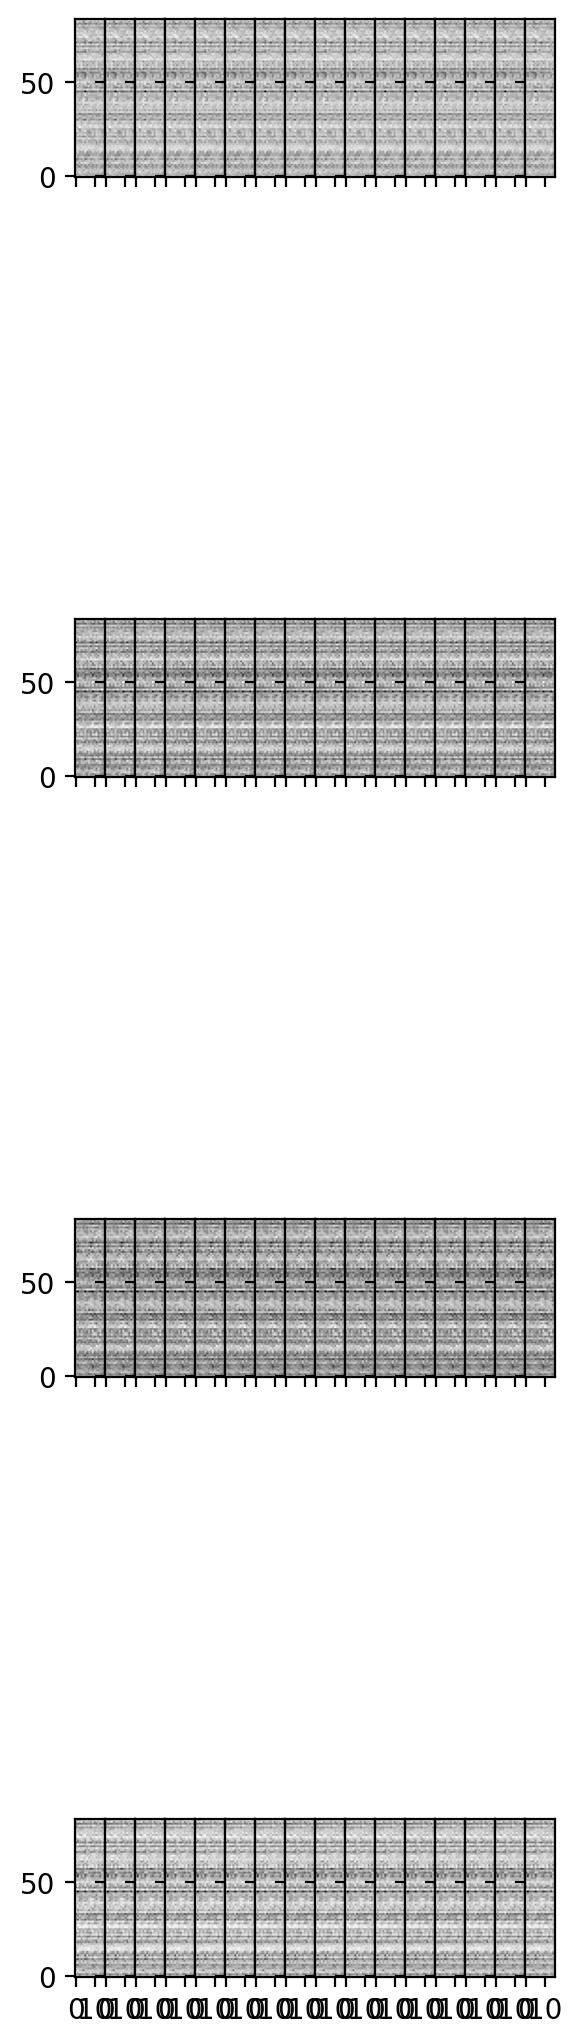

In [ ]:
num_scores = 1
chords_random_latent_vectors = np.random.normal(size=(num_scores, Z_DIM))
style_random_latent_vectors = np.random.normal(size=(num_scores, Z_DIM))
melody_random_latent_vectors = np.random.normal(
    size=(num_scores, N_TRACKS, Z_DIM)
)
groove_random_latent_vectors = np.random.normal(
    size=(num_scores, N_TRACKS, Z_DIM)
)
random_latent_vectors = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music = generator(random_latent_vectors)
generated_music = generated_music.numpy()

draw_score(generated_music, 0)
notes_to_midi(
    generated_music, N_BARS, N_TRACKS, N_STEPS_PER_BAR, filename="output_midi"
)

## Changing Chord Noise

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-db01838136f3>", line 11, in <cell line: 11>
    notes_to_midi(
  File "<ipython-input-15-7120de7101cd>", line 37, in notes_to_midi
    parts.write(
  File "/usr/local/lib/python3.10/dist-packages/music21/stream/base.py", line 391, in write
    return super().write(fmt=fmt, fp=fp, **keywords)
  File "/usr/local/lib/python3.10/dist-packages/music21/base.py", line 2815, in write
    return formatWriter.write(self,
  File "/usr/local/lib/python3.10/dist-packages/music21/converter/subConverters.py", line 1220, in write
    mf.open(fp, 'wb')  # write binary
  File "/usr/local/lib/python3.10/dist-packages/music21/midi/__init__.py", line 1544, in open
    self.file = open(filename, attrib)
OSError: [Errno 107] Transport endpoint is not connected: './Data/Generated/ChoralGAN/ou

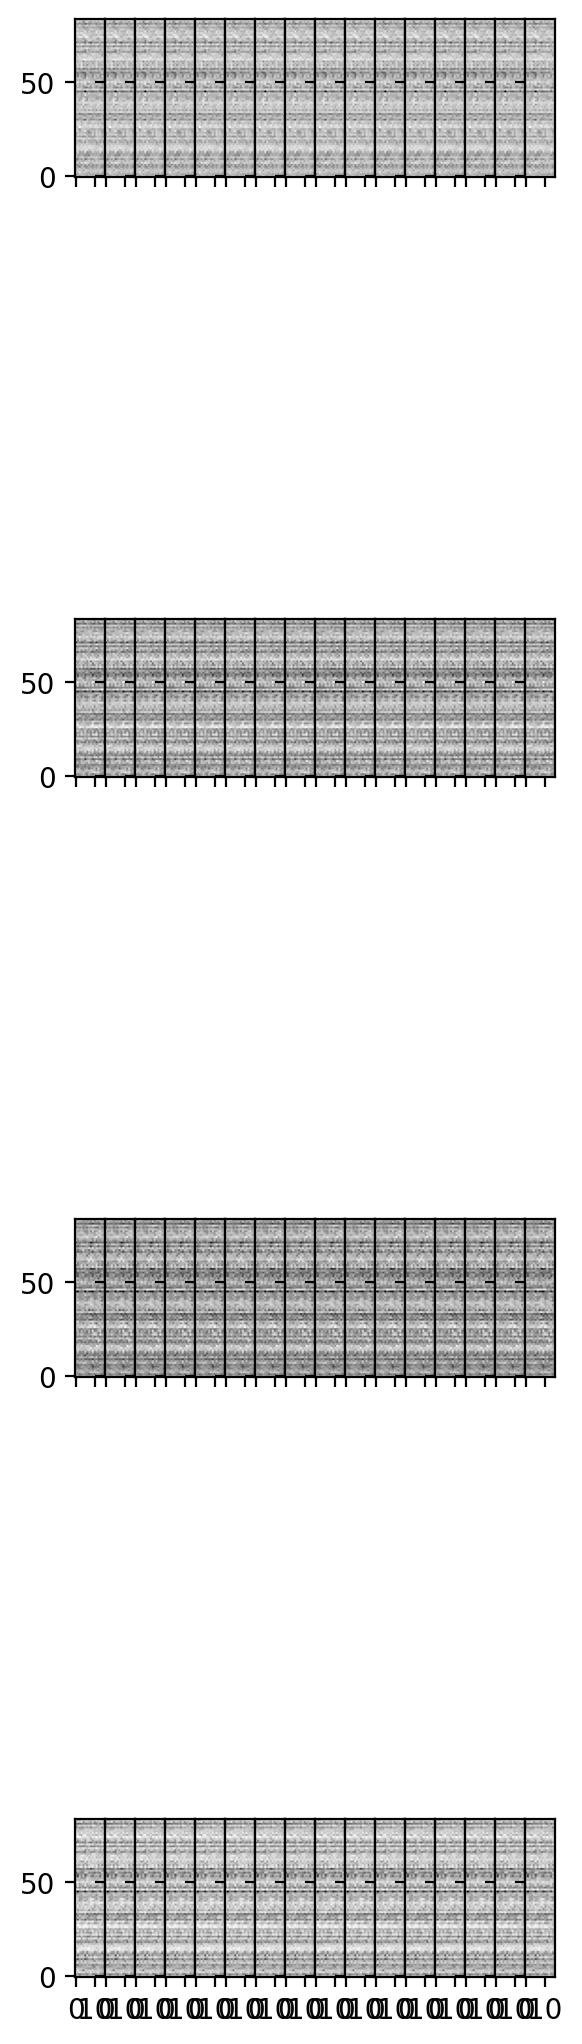

In [ ]:
chords_random_latent_vectors_2 = np.random.normal(size=(num_scores, Z_DIM))
random_latent_vectors_2 = [
    chords_random_latent_vectors_2,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music_2 = generator(random_latent_vectors_2)
generated_music_2 = generated_music_2.numpy()
draw_score(generated_music_2, 0)
notes_to_midi(
    generated_music_2,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_chords_changed",
)

# Changing Style Noise

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-fd7026f1ae1a>", line 11, in <cell line: 11>
    notes_to_midi(
  File "<ipython-input-15-7120de7101cd>", line 37, in notes_to_midi
    parts.write(
  File "/usr/local/lib/python3.10/dist-packages/music21/stream/base.py", line 391, in write
    return super().write(fmt=fmt, fp=fp, **keywords)
  File "/usr/local/lib/python3.10/dist-packages/music21/base.py", line 2815, in write
    return formatWriter.write(self,
  File "/usr/local/lib/python3.10/dist-packages/music21/converter/subConverters.py", line 1220, in write
    mf.open(fp, 'wb')  # write binary
  File "/usr/local/lib/python3.10/dist-packages/music21/midi/__init__.py", line 1544, in open
    self.file = open(filename, attrib)
OSError: [Errno 107] Transport endpoint is not connected: './Data/Generated/ChoralGAN/ou

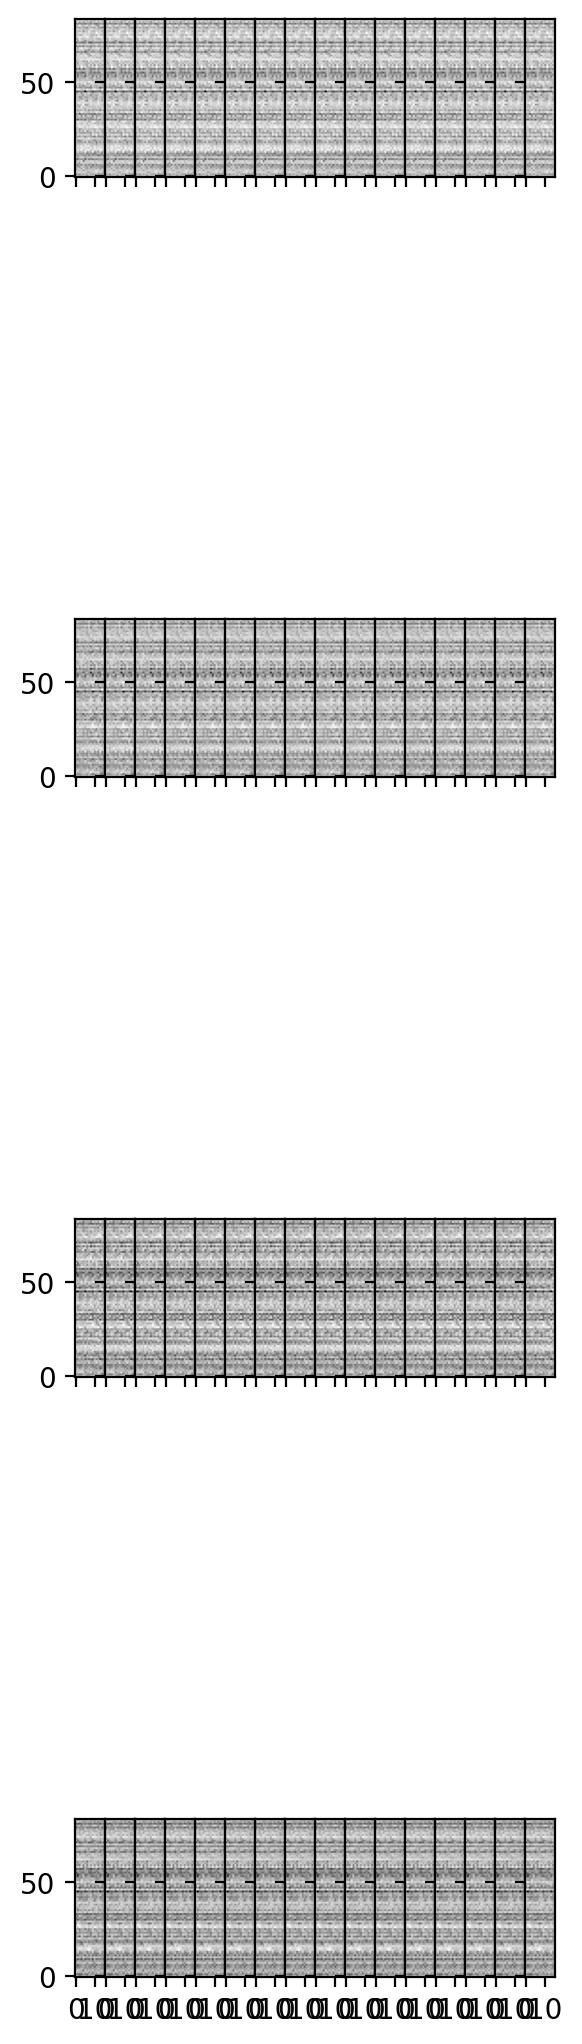

In [ ]:
style_random_latent_vectors_2 = np.random.normal(size=(num_scores, Z_DIM))
random_latent_vectors_3 = [
    chords_random_latent_vectors,
    style_random_latent_vectors_2,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music_3 = generator(random_latent_vectors_3)
generated_music_3 = generated_music_3.numpy()
draw_score(generated_music_3, 0)
notes_to_midi(
    generated_music_3,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_style_changed",
)

## Changing Melody Noise

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-3ce89c94854c>", line 15, in <cell line: 15>
    notes_to_midi(
  File "<ipython-input-15-7120de7101cd>", line 37, in notes_to_midi
    parts.write(
  File "/usr/local/lib/python3.10/dist-packages/music21/stream/base.py", line 391, in write
    return super().write(fmt=fmt, fp=fp, **keywords)
  File "/usr/local/lib/python3.10/dist-packages/music21/base.py", line 2815, in write
    return formatWriter.write(self,
  File "/usr/local/lib/python3.10/dist-packages/music21/converter/subConverters.py", line 1220, in write
    mf.open(fp, 'wb')  # write binary
  File "/usr/local/lib/python3.10/dist-packages/music21/midi/__init__.py", line 1544, in open
    self.file = open(filename, attrib)
OSError: [Errno 107] Transport endpoint is not connected: './Data/Generated/ChoralGAN/ou

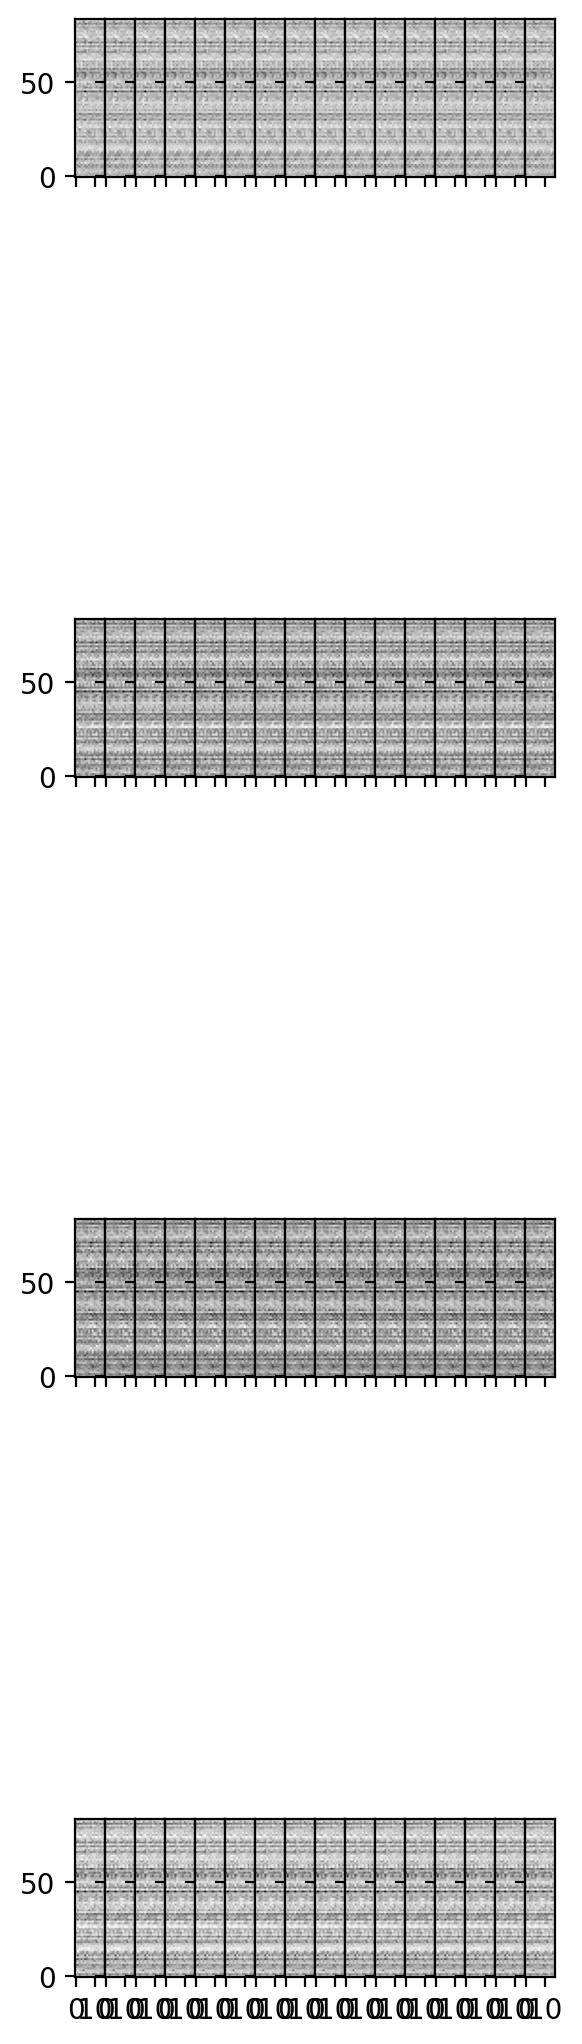

In [ ]:
melody_random_latent_vectors_2 = np.copy(melody_random_latent_vectors)
melody_random_latent_vectors_2[:, 0, :] = np.random.normal(
    size=(num_scores, Z_DIM)
)

random_latent_vectors_4 = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors_2,
    groove_random_latent_vectors,
]
generated_music_4 = generator(random_latent_vectors_4)
generated_music_4 = generated_music_4.numpy()
draw_score(generated_music_4, 0)
notes_to_midi(
    generated_music_4,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_melody_changed",
)

## Changing groove noise

In [ ]:
groove_random_latent_vectors_2 = np.copy(groove_random_latent_vectors)
groove_random_latent_vectors_2[:, -1, :] = np.random.normal(
    size=(num_scores, Z_DIM)
)

random_latent_vectors_5 = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors_2,
]
generated_music_5 = generator(random_latent_vectors_5)
generated_music_5 = generated_music_5.numpy()
draw_score(generated_music_5, 0)
notes_to_midi(
    generated_music_5,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_groove_changed",
)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-48c1c7043361>", line 15, in <cell line: 15>
    notes_to_midi(
  File "<ipython-input-15-7120de7101cd>", line 37, in notes_to_midi
    parts.write(
  File "/usr/local/lib/python3.10/dist-packages/music21/stream/base.py", line 391, in write
    return super().write(fmt=fmt, fp=fp, **keywords)
  File "/usr/local/lib/python3.10/dist-packages/music21/base.py", line 2815, in write
    return formatWriter.write(self,
  File "/usr/local/lib/python3.10/dist-packages/music21/converter/subConverters.py", line 1220, in write
    mf.open(fp, 'wb')  # write binary
  File "/usr/local/lib/python3.10/dist-packages/music21/midi/__init__.py", line 1544, in open
    self.file = open(filename, attrib)
OSError: [Errno 107] Transport endpoint is not connected: './Data/Generated/ChoralGAN/ou